In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import torch
torch.random.manual_seed(0xBADBEEF)

import os, sys
sys.path.append("..")
from frcl.datasets.split_mnist import SplitMnistDataset
from frcl.models import SplitMnistModel
from frcl.frcl import CLBaseline, FRCL
from torch.utils.data import DataLoader
from frcl.utils import CLDataLoader, cl_batch_to_device, cl_batch_target_float

# First task

In [13]:
batch_size = 100
learning_rate = 1e-5
device = 'cuda'
if device == 'cuda':
    torch.cuda.empty_cache()

In [14]:
train_0_1_dataset = SplitMnistDataset(0, 1, normalize=True)
train_0_1_dl = DataLoader(train_0_1_dataset, batch_size=batch_size, shuffle=True)
test_0_1_dataset = SplitMnistDataset(0, 1, train=False, normalize=True)
test_0_1_dl = DataLoader(test_0_1_dataset, batch_size=batch_size, shuffle=False)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [89]:
def make_x_y(hist):
    x = np.concatenate([np.linspace(i, i + 1, len(hist[i]), endpoint=False) for i in range(len(hist))])
    y = np.concatenate([np.asarray(epoch_hist) for epoch_hist in hist])
    return x, y

def train_model_once(train_loader, cl_model, optim, device):
    loss_hist = []
    curr_loss = 0.
    upd_factor = 20
    i = 0
    for X in train_loader:
       # cl_batch_to_device(X, device=device)
        cl_batch_target_float(X)
        optim.zero_grad()
        loss = cl_model(X[0].cuda(), X[1].cuda(), len(train_loader) * batch_size)
        loss.backward()
        optim.step()
        curr_loss += loss.item()
        if (i + 1) % upd_factor == 0:
            curr_loss /= upd_factor
            loss_hist.append(curr_loss)
            curr_loss = 0
        i += 1
    return loss_hist

def train_model(train_loader, cl_model, optim, max_epochs, device):
    loss_hist = []
    for e in range(max_epochs):
        loss = train_model_once(train_loader, cl_model, optim, device)
        loss_hist.append(loss)
        clear_output(wait=True)

        x, y = make_x_y(loss_hist)
        plt.plot(x, y)
        plt.title('Loss')
        plt.show()

In [90]:
base_model = SplitMnistModel()
cl_model = FRCL(base_model, base_model.hid, device, 1, 1).to(device)

In [91]:
optim_0_1 = torch.optim.Adam(cl_model.parameters(), lr=learning_rate)
train_loader = CLDataLoader()
train_loader.append(train_0_1_dataset, batch_size)

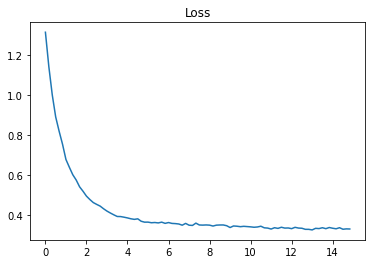

In [92]:
train_model(train_0_1_dl, cl_model, optim_0_1, 15, device)

In [93]:
cl_model.select_inducing(train_0_1_dl, criterion='deterministic')

Iteration 0 out of 300 is in progress
Current best statistic is  897.862
New points added  0 

Iteration 10 out of 300 is in progress
Current best statistic is  897.862
New points added  0 

Iteration 20 out of 300 is in progress
Current best statistic is  897.862
New points added  0 

Iteration 30 out of 300 is in progress
Current best statistic is  892.952
New points added  1 

Iteration 40 out of 300 is in progress
Current best statistic is  892.952
New points added  1 

Iteration 50 out of 300 is in progress
Current best statistic is  892.952
New points added  1 

Iteration 60 out of 300 is in progress
Current best statistic is  892.952
New points added  1 

Iteration 70 out of 300 is in progress
Current best statistic is  892.952
New points added  1 

Iteration 80 out of 300 is in progress
Current best statistic is  890.582
New points added  2 

Iteration 90 out of 300 is in progress
Current best statistic is  866.071
New points added  5 

Iteration 100 out of 300 is in progress
C

In [94]:
def accuracy(cl_model, test_dl, k):
    acc = []
    for x, target in test_dl:
        x_pred = cl_model.predict(x, k).cpu().numpy().argmax(axis=1)
        acc.append(np.sum(x_pred == target.cpu().numpy())/ len(x_pred))
    return np.mean(acc) 
print('task 0 1 after training task 0 1 accuracy:', accuracy(cl_model, test_0_1_dl, 0))  

task 0 1 after training task 0 1 accuracy: 0.9990909090909091


## Second task


In [95]:
train_2_3_dataset = SplitMnistDataset(2, 3, normalize=True)
train_2_3_dl = DataLoader(train_2_3_dataset, batch_size=batch_size, shuffle=True)
test_2_3_dataset = SplitMnistDataset(2, 3, train=False, normalize=True)
test_2_3_dl = DataLoader(test_2_3_dataset, batch_size=batch_size, shuffle=False)

In [96]:
optim_2_3 = torch.optim.Adam(cl_model.parameters(), lr=learning_rate)

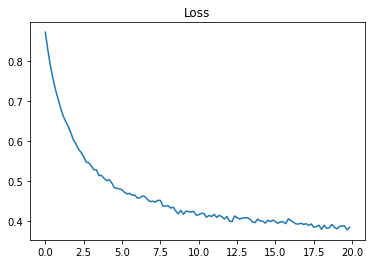

In [97]:
train_model(train_2_3_dl, cl_model, optim_2_3, 20, device)

In [98]:
cl_model.select_inducing(train_2_3_dl, criterion='deterministic')

Iteration 0 out of 300 is in progress
Current best statistic is  1010.954
New points added  0 

Iteration 10 out of 300 is in progress
Current best statistic is  1010.954
New points added  0 

Iteration 20 out of 300 is in progress
Current best statistic is  1010.954
New points added  0 

Iteration 30 out of 300 is in progress
Current best statistic is  1010.954
New points added  0 

Iteration 40 out of 300 is in progress
Current best statistic is  1010.954
New points added  0 

Iteration 50 out of 300 is in progress
Current best statistic is  1010.954
New points added  0 

Early stop activated


In [99]:
print('task 0 1 after training task 2 3 accuracy:', accuracy(cl_model, test_0_1_dl, 0))   
print('task 2 3 after training task 2 3 accuracy:', accuracy(cl_model, test_2_3_dl, 1))   

task 0 1 after training task 2 3 accuracy: 0.9968181818181818
task 2 3 after training task 2 3 accuracy: 0.9815419501133787


# Third task

In [100]:
train_4_5_dataset = SplitMnistDataset(4, 5, normalize=True)
train_4_5_dl = DataLoader(train_4_5_dataset, batch_size=batch_size, shuffle=True)
test_4_5_dataset = SplitMnistDataset(4, 5, train=False, normalize=True)
test_4_5_dl = DataLoader(test_4_5_dataset, batch_size=batch_size, shuffle=False)

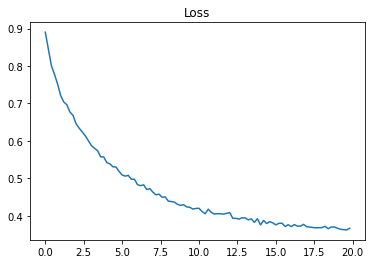

In [101]:
optim_4_5 = torch.optim.Adam(cl_model.parameters(), lr=learning_rate)
train_model(train_4_5_dl, cl_model, optim_4_5, 20, device)

In [102]:
cl_model.select_inducing(train_4_5_dl, criterion='deterministic')

Iteration 0 out of 300 is in progress
Current best statistic is  879.158
New points added  1 

Iteration 10 out of 300 is in progress
Current best statistic is  875.057
New points added  2 

Iteration 20 out of 300 is in progress
Current best statistic is  838.999
New points added  3 

Iteration 30 out of 300 is in progress
Current best statistic is  838.999
New points added  3 

Iteration 40 out of 300 is in progress
Current best statistic is  838.999
New points added  3 

Iteration 50 out of 300 is in progress
Current best statistic is  838.999
New points added  3 

Iteration 60 out of 300 is in progress
Current best statistic is  838.999
New points added  3 

Iteration 70 out of 300 is in progress
Current best statistic is  838.999
New points added  3 

Early stop activated


In [103]:
print('task 0 1 after training task 4 5 accuracy:', accuracy(cl_model, test_0_1_dl, 0))   
print('task 2 3 after training task 4 5 accuracy:', accuracy(cl_model, test_2_3_dl, 1))   
print('task 4 5 after training task 4 5 accuracy:', accuracy(cl_model, test_4_5_dl, 2))   

task 0 1 after training task 4 5 accuracy: 0.9949999999999999
task 2 3 after training task 4 5 accuracy: 0.9745124716553287
task 4 5 after training task 4 5 accuracy: 0.9984210526315789
